## Exploratory Notebook for GEDI Level 4A Data

Eventually this notebook should be incorporated into the src.data module.

Code based on this [NASA tutorial](https://github.com/ornldaac/gedi_tutorials/blob/main/1_gedi_l4a_search_download.ipynb).

In [3]:
# Autoreload source modules
# To immediately pick up code changes in src/
%load_ext autoreload
%autoreload 2

In [2]:
### Imports
import datetime as dt
import geopandas as gpd
import os
import pandas as pd
import requests
import concurrent
from tqdm.autonotebook import tqdm
import h5py
import numpy as np

/tmp/ipykernel_22265/1674210788.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
### Constants
doi = '10.3334/ORNLDAAC/1907'   # GEDI L4A DOI 
cmrurl='https://cmr.earthdata.nasa.gov/search/'     # CMR API base url
dt_format = '%Y-%m-%dT%H:%M:%SZ'    # CMR date time formatting string

# Spatial boundary
# (lon_min, lat_min, lon_max, lat_max)
bound = (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569)     # Brazil

# Temporal boundary
# start_date = dt.datetime(2019, 4, 18)
# end_date = dt.datetime(2020, 9, 2)     # Data for the full GEDI date range in Brazil is 2.3 TB
start_date = dt.datetime(2019, 7, 1)
end_date = dt.datetime(2019, 7, 31)     # Around 150 GB of data

In [5]:
# Get NASA EarthData's unique identifier for this dataset
doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']

# Use appropriate formatting for the space/time bounds
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
bound_str = ','.join(map(str, bound))


In [6]:
### Fetch a list of the URLs for the granules of interest
page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    cmr_params = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }
    granulesearch = cmrurl + 'granules.json'
    response = requests.get(granulesearch, params=cmr_params)
    granules = response.json()['feed']['entry']

    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
        
            # Read the file size in Mb
            granule_size = float(g['granule_size'])

            # Read the bounding polygons in this granule
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i = iter(poly[0].split (" "))
                    lat_lon = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in lat_lon]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break

# Add the spatial bounding box to the dataframe so we can plot it
b = list(bound)
granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])]) 

# Create a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

# Print metrics about the granules we will attempt to download
print ("Total granules found: ", len(l4adf.index)-1)
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  168
Total file size (MB):  151881.145214


(-34.7683777809, 6.24448639569)

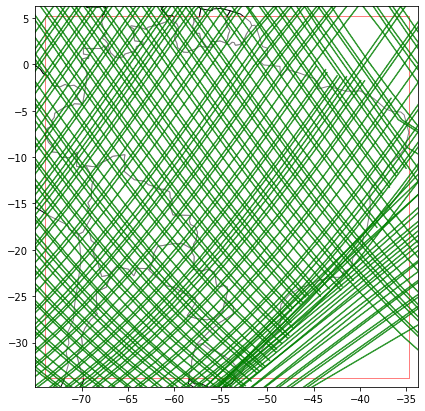

In [7]:
### Plot the granules using geopandas
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize  = (7, 7))

# last row contains the bounding box (Red)
ax= gdf[-1:].plot(ax=base, color='white', edgecolor='red', alpha=0.5)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.7)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)




In [8]:
# drop duplicate URLs if any and save to CSV
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)


In [9]:
links = l4a_granules.granule_url
for i in range(4):
    print(links[i])

https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019182013830_O03109_T00088_02_001_01.h5
https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5
https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019182044402_O03111_T04359_02_001_01.h5
https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2019182153324_O03118_T02790_02_001_01.h5


In [10]:
# Simple approach to download all specified files

# TODO: Parallelize: note that session is not thread-safe
s = requests.Session()
# Login to get session cookies in s.cookies
login_data = {"login": USER, "password": PWD}
s.post(URL, data=login_data)     

links = l4a_granules.granule_url[6:36]
for link in tqdm(links):
    local_filename = link.split('/')[-1]
    with s.get(link, stream=True) as r:
        size_bytes = int(r.headers.get('content-length', 0))
        progress_bar = tqdm(total=size_bytes, unit='iB', unit_scale=True)
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                progress_bar.update(len(chunk))
                f.write(chunk)
    progress_bar.close()




  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0.00/1.06G [00:00<?, ?iB/s]

  0%|          | 0.00/998M [00:00<?, ?iB/s]

  0%|          | 0.00/904M [00:00<?, ?iB/s]

  0%|          | 0.00/1.18G [00:00<?, ?iB/s]

  0%|          | 0.00/880M [00:00<?, ?iB/s]

  0%|          | 0.00/575M [00:00<?, ?iB/s]

  0%|          | 0.00/1.10G [00:00<?, ?iB/s]

  0%|          | 0.00/1.00G [00:00<?, ?iB/s]

  0%|          | 0.00/715M [00:00<?, ?iB/s]

  0%|          | 0.00/1.17G [00:00<?, ?iB/s]

  0%|          | 0.00/855M [00:00<?, ?iB/s]

  0%|          | 0.00/596M [00:00<?, ?iB/s]

  0%|          | 0.00/820M [00:00<?, ?iB/s]

  0%|          | 0.00/1.11G [00:00<?, ?iB/s]

  0%|          | 0.00/899M [00:00<?, ?iB/s]

  0%|          | 0.00/1.09G [00:00<?, ?iB/s]

  0%|          | 0.00/735M [00:00<?, ?iB/s]

  0%|          | 0.00/799M [00:00<?, ?iB/s]

  0%|          | 0.00/734M [00:00<?, ?iB/s]

  0%|          | 0.00/1.06G [00:00<?, ?iB/s]

  0%|          | 0.00/921M [00:00<?, ?iB/s]

  0%|          | 0.00/1.14G [00:00<?, ?iB/s]

  0%|          | 0.00/1.02G [00:00<?, ?iB/s]

  0%|          | 0.00/812M [00:00<?, ?iB/s]

  0%|          | 0.00/1.09G [00:00<?, ?iB/s]

  0%|          | 0.00/968M [00:00<?, ?iB/s]

  0%|          | 0.00/1.13G [00:00<?, ?iB/s]

  0%|          | 0.00/836M [00:00<?, ?iB/s]

  0%|          | 0.00/587M [00:00<?, ?iB/s]

  0%|          | 0.00/1.10G [00:00<?, ?iB/s]

In [7]:

from dotenv import dotenv_values
import os

URL = "https://urs.earthdata.nasa.gov/cookies"
config = dotenv_values("/home/users/ah2174/gedi-biomass-mapping/.env")
print(config)
s = requests.Session()
# Login to get session cookies in s.cookies
login_data = {"login": config["EARTHDATA_USER"], "password": config["EARTHDATA_PASSWORD"]}
s.post(URL, data=login_data)    
s.cookies 

OrderedDict([('EARTHDATA_USER', 'AmeliaH'), ('EARTHDATA_PASSWORD', 'egEVQvYQYpnK7*R@n8nA'), ('DB_HOST', ''), ('DB_NAME', ''), ('DB_USER', ''), ('DB_PASSWORD', '')])


<RequestsCookieJar[Cookie(version=0, name='_urs-gui_session', value='87f411355c3bd6ce8c59f4418ad4a4ce', port=None, port_specified=False, domain='urs.earthdata.nasa.gov', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=False, expires=1637145300, discard=False, comment=None, comment_url=None, rest={'HttpOnly': None}, rfc2109=False)]>

In [66]:

TEST_FILE = "/home/users/ah2174/GEDI04_A_2019182013830_O03109_T00088_02_001_01.h5"
TEST_FILE_LP = "GEDI02_A_2020101002520_O07513_03_T04382_02_003_01_V002"
from src.data.gedi_granule import GediGranule

granule = GediGranule(TEST_FILE)
beam = granule.beam(4)
beam.main_data.algorithm_run_flag


/home/users/ah2174/gedi-biomass-mapping/src/data/gedi_granule.py:389: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  geometry = self.shot_geolocations
/home/users/ah2174/gedi-biomass-mapping/src/data/gedi_granule.py:328: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geolocations = np.array(


0         0
1         0
2         0
3         0
4         0
         ..
410259    0
410260    0
410261    0
410262    0
410263    0
Name: algorithm_run_flag, Length: 410264, dtype: uint8

In [13]:
times = [14.9 , 36.6 , 37.5 , 41 , 13.2 , 18 , 3.78 , 9.46 , 39.7 , 40.6 , 38.1 , 39.1 , 40.1 , 38.2 , 38.9 , 22.4 , 22.7 , 28.3 , 38.1 , 35.8 , 39.8 , 38.4 , 27.9 , 37.4 , 37.1 , 26 , 42.4 , 38.5 , 30.3 , 32.2]
print(len(times))
sum(times)/len(times)

30


31.547999999999995

In [14]:
# How many of the shots have algorithm run flag set to true
from collections import defaultdict
files = os.listdir(DEST_FOLDER)
# lon_min, lat_min, lon_max, lat_max
bound = (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569) 
shots = 0
usable = 0
d = defaultdict(int)
for file_name in tqdm(files):
    f = h5py.File(file_name,'r')
    for k in f.keys():
        if k.startswith('BEAM'):
            beam  = f.get(k)
            lat = beam.get('lat_lowestmode')[:]
            lon = beam.get('lon_lowestmode')[:]
            alg_run = beam.get('algorithm_run_flag')[:]

            lats_in_range = np.logical_and(lat > bound[1], lat < bound[3])
            lons_in_range = np.logical_and(lon > bound[0], lon < bound[2])
            idx_in_range = np.where(np.logical_and(lats_in_range, lons_in_range))
            if(np.sum(np.logical_and(lats_in_range, lons_in_range)) != 0):
                d[file_name] += 1
            shots += idx_in_range[0].shape[0]
            usable += np.sum(alg_run[idx_in_range])
    f.close()

# Sanity check: every file should have at least one shot in range
print(len(d.keys()))
print(shots)
print(usable)
print(usable/shots)

  0%|          | 0/35 [00:00<?, ?it/s]

GEDI04_A_2019182013830_O03109_T00088_02_001_01.h5_BEAM0110: 55315
GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5_BEAM0000: 82571
GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5_BEAM0001: 79937
GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5_BEAM0010: 83108
GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5_BEAM0011: 79994
GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5_BEAM0101: 79981
GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5_BEAM0110: 112074
GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5_BEAM1000: 82470
GEDI04_A_2019182031116_O03110_T00089_02_001_01.h5_BEAM1011: 80089
GEDI04_A_2019182044402_O03111_T04359_02_001_01.h5_BEAM0000: 44995
GEDI04_A_2019182044402_O03111_T04359_02_001_01.h5_BEAM0001: 45003
GEDI04_A_2019182044402_O03111_T04359_02_001_01.h5_BEAM0010: 45012
GEDI04_A_2019182044402_O03111_T04359_02_001_01.h5_BEAM0011: 45039
GEDI04_A_2019182044402_O03111_T04359_02_001_01.h5_BEAM0101: 45033
GEDI04_A_2019182044402_O03111_T04359_02_001_01.h5_BEAM0110: 45046
GEDI04_A_